In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import math

# fit the value-based decision model
from scipy.optimize import minimize
from scipy.special import softmax

from sklearn.model_selection import LeaveOneOut
from random import sample
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')
datapath = '/content/drive/MyDrive/Help_Decision_Modeling/Github/'

Mounted at /content/drive


# Load Data

In [4]:
# Task 1 data
data_decisions = pd.read_csv(datapath+'data/Task1_Final.csv')
data_decisions = data_decisions.drop(columns = ['Mean','SD','ValidS'],axis=1)
# Task 2 data
data_ratings = pd.read_csv(datapath+'data/Task2_scenario_ratings_AC_Var_Mean.csv',index_col=0)
# Task 2 factors
mot_fa = pd.read_csv(datapath+'output/FA_scores.csv',index_col=0)
data_ratings = data_ratings.merge(mot_fa,left_index=True, right_index=True)

# Mixed-effect GLM (Fig_S2)

In [49]:
allvars_allitems = data_ratings[['Guilt','Neg_SelfConcept','Benefit_O_H','Reciprocity','Des_Norm','Inj_Norm','Empathy','Pos_SelfConcept','Mood','Reputation','Cost_O_NH','Cost_S_H']]
allvars_allitems = allvars_allitems / 4 - 1/4 # recode [1,2,3,4,5] to [0,0.25,0.5,0.75,1]

# the final aggregated data
import warnings

# Disable warnings for this cell
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    data_model_allitems = []
    # for each subject
    for row in range(len(data_decisions)):
        willingness = data_decisions.iloc[row,:].dropna()
        ID = willingness['PROLIFIC_PID']
        willingness = willingness.drop('PROLIFIC_PID').transpose()
        willingness = willingness.rename(index=lambda x: 'S' + x[1:])
        data_S = willingness.to_frame(name = 'WTH')
        data_S['WTH'] = pd.to_numeric(data_S['WTH'])
        data_S['Decision'] = (data_S['WTH']>0).astype(int) # binarize the choice
        # merge the rating spreadsheet
        data_S = data_S.join(allvars_allitems,how = 'left')
        data_S = data_S.dropna()

        # append the data to the list
        data_model_allitems.append([ID, data_S])

In [52]:
# organize the data, concatenate to a big dataframe
df_glme = None
for each in data_model_allitems:
    df_sub = each[1].reset_index()
    df_sub.rename(columns={'index': 'Scenario'}, inplace=True)
    df_sub['ID'] = each[0]
    if df_glme is None:
        df_glme = df_sub
    else:
        df_glme = pd.concat([df_glme,df_sub],axis=0)
df_glme = df_glme.reset_index(drop=True)
df_glme

,Scenario,WTH,Decision,Guilt,Neg_SelfConcept,Benefit_O_H,Reciprocity,Des_Norm,Inj_Norm,Empathy,Pos_SelfConcept,Mood,Reputation,Cost_O_NH,Cost_S_H,ID
0,S2,1.0,1,0.366071,0.330357,0.633929,0.638889,0.482143,0.500000,0.481481,0.455357,0.410714,0.446429,0.473214,0.482143,Z6PMZ8UK
1,S4,-5.0,0,0.205357,0.178571,0.490741,0.472222,0.473214,0.473214,0.410714,0.303571,0.312500,0.222222,0.196429,0.339286,Z6PMZ8UK
2,S7,5.0,1,0.703704,0.574074,0.861111,0.879630,0.759259,0.796296,0.851852,0.611111,0.657407,0.574074,0.712963,0.201923,Z6PMZ8UK
3,S9,3.0,1,0.805556,0.730769,0.944444,0.942308,0.898148,0.898148,0.861111,0.711538,0.685185,0.722222,0.879630,0.336538,Z6PMZ8UK
4,S10,1.0,1,0.410714,0.296296,0.607143,0.651786,0.464286,0.535714,0.687500,0.500000,0.446429,0.490741,0.419643,0.305556,Z6PMZ8UK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10716,S91,3.0,1,0.336538,0.360000,0.701923,0.740000,0.596154,0.605769,0.663462,0.560000,0.519231,0.519231,0.346154,0.240000,32YYU5O8
10717,S93,3.0,1,0.571429,0.574074,0.785714,0.826923,0.660714,0.687500,0.750000,0.620370,0.660714,0.553571,0.607143,0.361111,32YYU5O8
10718,S94,1.0,1,0.405172,0.370690,0.723214,0.714286,0.577586,0.681034,0.724138,0.620690,0.655172,0.625000,0.336207,0.301724,32YYU5O8
10719,S95,1.0,1,0.740741,0.701923,0.916667,0.923077,0.833333,0.861111,0.879630,0.653846,0.657407,0.601852,0.759259,0.222222,32YYU5O8


In [53]:
def marginal_r(results, df, varname):
  # 1. Fixed effects predictions
  fixed_effects = results.fittedvalues

  # 2. Total variance of observed values
  var_y = np.var(df[varname], ddof=1)

  # 3. Marginal R²: fixed effect only
  var_fixed = np.var(fixed_effects, ddof=1)
  r2_marginal = var_fixed / var_y

  # 4. Random effect variance
  var_random = np.trace(results.cov_re)  # variance of random intercepts/slopes
  var_resid = results.scale  # residual variance

  # 5. Conditional R²: fixed + random effects
  r2_conditional = (var_fixed + var_random) / (var_fixed + var_random + var_resid)

  return r2_marginal,r2_conditional


In [54]:
# run mixed-effet multiple linear regression
varlist = ['Guilt','Neg_SelfConcept','Benefit_O_H','Reciprocity','Des_Norm','Inj_Norm','Empathy','Pos_SelfConcept','Mood','Reputation','Cost_O_NH','Cost_S_H']
labellist = ['Feeling of guilt','Not help negatively influence self-concept','Other\'s benefit from being helped',
           'Want to receive such help in the future','Peers\' likelihood of help', 'Peers think one should help',
            'Empathize with other','Help improve positive self-concept','Help improve mood',
          'Improve self reputation if help', 'Other\'s bad consequence if not help','Self cost if help']
r2_marg_all = []
r2_cond_all = []
for x in varlist:
  model_measuredvar = smf.mixedlm(f"WTH ~ {x}", df_glme, groups=df_glme["ID"], re_formula=f"~ {x}").fit(method = ["lbfgs"])
  r2_marginal,r2_cond = marginal_r(model_measuredvar, df_glme, "WTH")
  r2_marg_all.append(r2_marginal)
  r2_cond_all.append(r2_cond)
# Create a DataFrame for easier plotting
r2_df = pd.DataFrame({
    'Variable': varlist,
    'Label': labellist,
    'Marginal R2': r2_marg_all,
    'Conditional R2': r2_cond_all
})

# Sort the DataFrame by Conditional R2 for better visualization
r2_df = r2_df.sort_values('Conditional R2')


In [56]:
!pip install pyfonts
from pyfonts import load_google_font
import matplotlib as mpl
import matplotlib.font_manager as fm

# Load and register font only once
font_prop = load_google_font("Arimo")
fm.fontManager.addfont(font_prop.get_file())
mpl.rcParams['font.family'] = font_prop.get_name()

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-684016169.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax.barh(y_pos, r2_df['Conditional R2'], bar_width, label='Conditional  $\mathregular{R^{2}}$', color='#ffd5a8')
/tmp/ipython-input-684016169.py:10: SyntaxWarning: invalid escape sequence '\m'
  ax.barh(y_pos, r2_df['Marginal R2'], bar_width, label='Marginal $\mathregular{R^{2}}$', color='#fc8d17')
/tmp/ipython-input-684016169.py:15: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Linear Mixed Effect Model $\mathregular{R^{2}}$',fontsize=14)


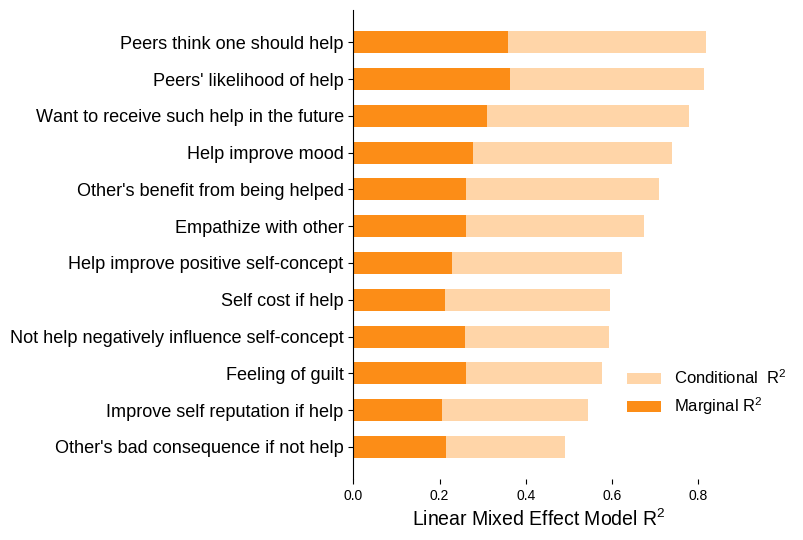

In [57]:
fig, ax = plt.subplots(figsize=(7.5, 5.5))

bar_width = 0.6
y_pos = np.arange(len(r2_df['Variable']))

# Plot Conditional R2 bars (bottom layer)
ax.barh(y_pos, r2_df['Conditional R2'], bar_width, label='Conditional  $\mathregular{R^{2}}$', color='#ffd5a8')

# Plot Marginal R2 bars (top layer)
ax.barh(y_pos, r2_df['Marginal R2'], bar_width, label='Marginal $\mathregular{R^{2}}$', color='#fc8d17')

# Set y-axis labels and title
ax.set_yticks(y_pos)
ax.set_yticklabels(r2_df['Label'],fontsize=13)
ax.set_xlabel('Linear Mixed Effect Model $\mathregular{R^{2}}$',fontsize=14)

ax.legend(frameon=False, fontsize=12,loc='lower left',bbox_to_anchor=(0.7, 0.1))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig(datapath + 'output/Figures/Fig_S2/Fig_S2.svg',dpi=300, format='svg', bbox_inches='tight')

# Reorganize data for modeling

Each subject data should have the decision rating, the binarized decision, and the 7 key variables:
1. Cost_S_H
2. Benefit_O_H
3. Benefit_S_H
4. Cost_O_NH
5. Cost_S_NH
6. Empathy
7. Urgency

In [5]:
allvars = data_ratings[['Urgency']]
allvars['F1_Benefit'] = (data_ratings['MR1']-data_ratings['MR1'].min())/(data_ratings['MR1'].max()-data_ratings['MR1'].min())
allvars['F2_Cost'] = (data_ratings['MR2']-data_ratings['MR2'].min())/(data_ratings['MR2'].max()-data_ratings['MR2'].min())
allvars

/tmp/ipython-input-1756023978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allvars['F1_Benefit'] = (data_ratings['MR1']-data_ratings['MR1'].min())/(data_ratings['MR1'].max()-data_ratings['MR1'].min())
/tmp/ipython-input-1756023978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allvars['F2_Cost'] = (data_ratings['MR2']-data_ratings['MR2'].min())/(data_ratings['MR2'].max()-data_ratings['MR2'].min())


,Urgency,F1_Benefit,F2_Cost
S1,2.346154,0.477833,0.007691
S2,3.142857,0.275308,0.716325
S3,4.500000,0.740135,0.415999
S4,1.964286,0.068083,0.394211
S5,3.535714,0.663044,0.367494
...,...,...,...
S96,2.724138,0.510948,0.293052
S97,2.857143,0.563156,0.066176
S98,2.280000,0.239317,0.216362
S99,4.896552,0.939891,0.307431


In [6]:
# the final aggregated data
import warnings

# Disable warnings for this cell
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    data_model = []
    # for each subject
    for row in range(len(data_decisions)):
        willingness = data_decisions.iloc[row,:].dropna()
        ID = willingness['PROLIFIC_PID']
        willingness = willingness.drop('PROLIFIC_PID').transpose()
        willingness = willingness.rename(index=lambda x: 'S' + x[1:])
        data_S = willingness.to_frame(name = 'WTH')
        data_S['WTH'] = pd.to_numeric(data_S['WTH'])
        data_S['Decision'] = (data_S['WTH']>0).astype(int) # binarize the choice
        # merge the rating spreadsheet
        data_S = data_S.join(allvars,how = 'left')
        # append the data to the list
        data_model.append([ID, data_S])

# Value-based Decision Model

## Model fitting functions

In [7]:
def fit_model(df,VBD_model,init_params,param_bounds):
    """
    Fit the model to the data by minimizing the negative log likelihood.
    """
    # Minimize the negative log likelihood
    result = minimize(VBD_model, init_params, args=(df),
                      method='L-BFGS-B', bounds=param_bounds)

    # Extract fitted parameters
    fitted_params = result.x
    return fitted_params, result.fun


In [8]:
def pseudo_r_squared(fit_llh, df, mode):
    """
    mode 1: McFadden's pseudo R-squared for the model
    mode 2: null model is all 0.5
    """
    epsilon = 1e-5 # prevent underflow

    # Null model
    choices = df['Decision'].dropna()
    if mode == 1:
        # 1. fixed choice as baseline
        p = np.mean(choices)  # Mean probability of choosing 1
        null_llh = np.sum(choices * np.log(p + epsilon) + (1 - choices) * np.log(1 - p + epsilon))
    else:
        # 2. 0.5 probability as baseline
        null_llh = np.log(0.5)*len(df.dropna())
        # Calculate McFadden's pseudo R-squared
        r_squared = 1 - (fit_llh / null_llh)

    return r_squared


In [9]:
def info_criteria(fit_llh,k,df):
    """
    AIC and BIC
    fit_llh: the loglikelihood (not negative)
    k: number of parameters
    """
    AIC = 2*k - 2*fit_llh

    n = len(df.dropna())
    BIC = np.log(n)*k - 2*fit_llh

    return AIC,BIC


In [10]:
def fit_alldata(data_all,VBD_model,init_params,param_bounds,param_names,fit_model,cross_val,gen_model):
    """
    Fit all participant data in the dataset, and output fitting summaries.
    data_all: list of data files, each element is [ID, datamatrix]
    VBD_model: the main model function
    init_params: parameter initialization value
    param_bounds: parameter boundings
    param_names: name of parameters
    fit_model: the function called 'fit_model'
    cross_val: whether apply cross validation, if apply, True
    gen_model: the sample generator model
    """

    r_squared = []
    params_all = []
    llh_all = []
    AIC_all = []
    BIC_all = []

    for each in data_all:
        fitted_params, neg_log_likelihood = fit_model(each[1],VBD_model,init_params,param_bounds)
        params_all.append(fitted_params)
        llh_all.append(neg_log_likelihood)
        r_squared.append(pseudo_r_squared(-neg_log_likelihood, each[1],2))
        AIC,BIC = info_criteria(-neg_log_likelihood,len(fitted_params),each[1])
        AIC_all.append(AIC)
        BIC_all.append(BIC)

    params_array = np.asarray(params_all)
    model_fit_df = pd.DataFrame({
        'ID': data_decisions['PROLIFIC_PID'],
        'neg_llh': llh_all,
        'r2':r_squared,
        'AIC':AIC_all,
        'BIC':BIC_all,
    })
    for i,parname in enumerate(param_names):
        model_fit_df[parname] = params_array[:, i]


    # cross-validation
    if cross_val == True:
        pred_allsub_df,test_acc_all = LOO_cross_validate(data_model, VBD_model, init_params, param_bounds, param_names, fit_model, gen_model)
        model_fit_df['test_acc'] = test_acc_all
    else:
        pred_allsub_df = None

    return pred_allsub_df,model_fit_df

In [11]:
def LOO_cross_validate(data_all, VBD_model, init_params, param_bounds, param_names, fit_model, gen_model):
    """
    Perform cross validation and get out-of-sample prediction accuracy as a model comparison measure.
    Leave-one-out cross validation
    """
    test_acc_all = np.full(len(data_all),np.nan)
    pred_allsub_df = None
    for i,each in enumerate(data_all):
        if i % 20 == 19:
            print(i)
        loo = LeaveOneOut()
        data_sub = each[1]
        loo.get_n_splits(data_sub)
        pred_list = np.full(len(data_sub),np.nan)
        # loop over all the k folds
        for j, (train_index, test_index) in enumerate(loo.split(data_sub)):
            data_train = data_sub.iloc[train_index,:]
            data_test = data_sub.iloc[test_index,:]
            fitted_params, neg_log_likelihood = fit_model(data_train,VBD_model,init_params,param_bounds)
            choices, pred_list[test_index] = gen_model(fitted_params, data_test)
        # save the predictions
        data_sub['Pred_choice'] = pred_list
        data_sub['ID'] = each[0]
        data_sub = data_sub.reset_index(names = 'Scenario')

        # initiate the final output dataset
        if pred_allsub_df is None:
            pred_allsub_df = data_sub
        else:
            pred_allsub_df = pd.concat([pred_allsub_df,data_sub],axis=0)

        test_acc_all[i]=np.mean(1*(data_sub.dropna()['Pred_choice'] == data_sub.dropna()['Decision']).values)

    return pred_allsub_df,test_acc_all

## VBD Models

### VBD_M1: fixed helping propensity model

In [12]:
def VBD_M1(params,df):
    """
    Value-based decision model - fixed value
    - Parameters: b, beta
    - Known variables: NA
    - Output: the probability of help
    """
    # extract parameters
    b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = 0
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))*np.ones(len(df))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [13]:
def genchoice_VBD_M1(params,df):
    # extract parameters
    b,  beta = params
    # compute the value signal
    Value_Help = 0
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))*np.ones(len(df))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

### VBD_M2: Single weight model

AV(help) = w_self(-F2_Cost) + (1-w_self)*(F1_Benefit) + b

In [14]:
def VBD_M2(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, b, beta
    - Known variables: F1_Benefit, F2_Cost
    - Output: the probability of help
    """
    # extract parameters
    w_cost, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + (1 - w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [15]:
def genchoice_VBD_M2(params,df):
    # extract parameters
    w_cost, b,  beta = params

    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + (1 - w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

### VBD_M3: Use 2 orthogonal weights for cost and benefit

In [16]:
def VBD_M3(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, w_benefit, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, w_benefit, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + w_benefit * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [17]:
def genchoice_VBD_M3(params,df):
    # extract parameters
    w_cost, w_benefit, b,  beta = params
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + w_benefit * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

### VBD_M2_1: Nonlinear Cost

use 1 weight, but another nonlinear term alpha on cost.

In [18]:
def VBD_M2_1(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, w_benefit, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, alpha, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']**alpha) + (1-w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [19]:
def genchoice_VBD_M2_1(params,df):
    # extract parameters
    w_cost, alpha, b,  beta = params
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']**alpha) + (1-w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

### VBD_M2_2: Nonlinear Benefit
use 1 weight but nonlinear term alpha on benefit

In [20]:
def VBD_M2_2(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, alpha, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, alpha, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * df['F2_Cost'] + (1-w_cost) * df['F1_Benefit']**alpha
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [21]:
def genchoice_VBD_M2_2(params,df):
    # extract parameters
    w_cost, alpha, b,  beta = params
    # compute the value signal
    Value_Help = - w_cost * df['F2_Cost'] + (1-w_cost) * df['F1_Benefit']**alpha
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

### VBD_M2_3: Interaction term

In [22]:
def VBD_M2_3(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, w_magnitude, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + (1 - w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b + w_magnitude*df['F2_Cost']*df['F1_Benefit']
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [23]:
def genchoice_VBD_M2_3(params,df):
    # extract parameters
    w_cost, w_magnitude, b,  beta = params
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + (1 - w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b + w_magnitude*df['F2_Cost']*df['F1_Benefit']
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

### VBD_M2_4: Urgency Bonus

In [24]:
def VBD_M2_4(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, alpha, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, b, w_urgency, beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * df['F2_Cost'] + (1-w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    # urgency binary variable
    urgency = 1*(df['Urgency']>0.567)
    thres = b + w_urgency * urgency
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [25]:
def genchoice_VBD_M2_4(params,df):
    # extract parameters
    w_cost, b, w_urgency, beta = params
    # compute the value signal
    Value_Help = - w_cost * df['F2_Cost'] + (1-w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    # urgency binary variable
    urgency = 1*(df['Urgency']>0.567)
    thres = b + w_urgency * urgency
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

## Fit each model

### VBD_M1

19
39
59
79
99
119
139
159
179
199
R2 = 0.264
AIC = 54.843
BIC = 58.661
Out of sample prediction ACC = 0.743


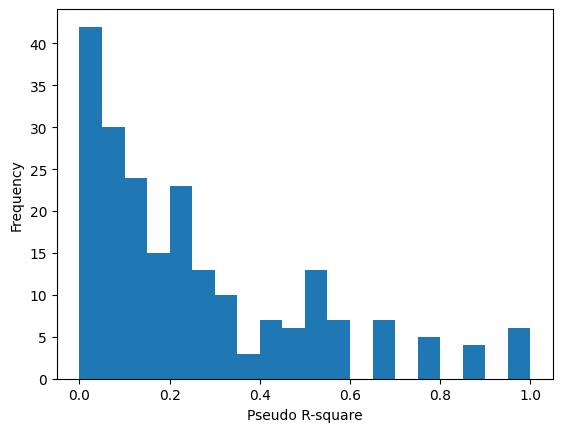

In [27]:
VBD_model = VBD_M1
gen_model = genchoice_VBD_M1
folder_name = 'VBD_M1'
init_params = np.array([0.7,1])
param_bounds =  [(-1, 1), (1e-5,10)]
param_names = ['b','beta']

pred_allsub_df_m1, model_fit_m1 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,True,gen_model)

# Save the model output
model_fit_m1.to_csv(datapath+'output/Model/'+folder_name+'/model_fits.csv',index=False)
pred_allsub_df_m1.to_csv(datapath+'output/Model/'+folder_name+'/LOO_pred.csv',index=False)

print(f'R2 = {np.round(np.mean(model_fit_m1['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m1['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m1['BIC']),3)}')
print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m1['test_acc']),3)}')

### VBD_M2

In [32]:
VBD_model = VBD_M2
gen_model = genchoice_VBD_M2
folder_name = 'VBD_M2'
init_params = np.array([-0.8, 0, 2])
param_bounds =  [(0, 1), (-1,1), (1e-5,10)]
param_names = ['w_cost','b','beta']

pred_allsub_df_m2, model_fit_m2 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,False,gen_model)

In [30]:
VBD_model = VBD_M2
gen_model = genchoice_VBD_M2
folder_name = 'VBD_M2'
init_params = np.array([-0.8, 0, 2])
param_bounds =  [(0, 1), (-1,1), (1e-5,10)]
param_names = ['w_cost','b','beta']

pred_allsub_df_m2, model_fit_m2 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,True,gen_model)

# Save the model output
model_fit_m2.to_csv(datapath+'output/Model/'+folder_name+'/model_fits.csv',index=False)
pred_allsub_df_m2.to_csv(datapath+'output/Model/'+folder_name+'/LOO_pred.csv',index=False)

print(f'R2 = {np.round(np.mean(model_fit_m2['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m2['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m2['BIC']),3)}')
print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m2['test_acc']),3)}')

19
39
59
79
99
119
139
159
179
199
R2 = 0.419
AIC = 46.121
BIC = 51.849
Out of sample prediction ACC = 0.787


### VBD_M3

In [41]:
VBD_model = VBD_M3
gen_model = genchoice_VBD_M3
folder_name = 'VBD_M3'
init_params = np.array([0.8, 0.5, 0.3, 2])
param_bounds =  [(-3, 3), (-3,3), (-3,3), (1e-5,10)]
param_names = ['w_cost','w_benefit','b','beta']

pred_allsub_df_m3, model_fit_m3 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,True,gen_model)

# Save the model output
model_fit_m3.to_csv(datapath+'output/Model/'+folder_name+'/model_fits.csv',index=False)
pred_allsub_df_m3.to_csv(datapath+'output/Model/'+folder_name+'/LOO_pred.csv',index=False)


print(f'R2 = {np.round(np.mean(model_fit_m3['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m3['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m3['BIC']),3)}')
print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m3['test_acc']),3)}')

19
39
59
79
99
119
139
159
179
199
R2 = 0.428
AIC = 47.536
BIC = 55.173
Out of sample prediction ACC = 0.785


### VBD_M2_1

In [27]:
VBD_model = VBD_M2_1
gen_model = genchoice_VBD_M2_1
folder_name = 'VBD_M2_1'
init_params = np.array([0.8, 0.5, 0.3, 2])
param_bounds =  [(0, 1), (0,3), (-3,3), (1e-5,10)]
param_names = ['w_cost','alpha','b','beta']

pred_allsub_df_m2_1, model_fit_m2_1 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,True,gen_model)

# Save the model output
model_fit_m2_1.to_csv(datapath+'output/Model/'+folder_name+'/model_fits.csv',index=False)
pred_allsub_df_m2_1.to_csv(datapath+'output/Model/'+folder_name+'/LOO_pred.csv',index=False)

print(f'R2 = {np.round(np.mean(model_fit_m2_1['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m2_1['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m2_1['BIC']),3)}')
print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m2_1['test_acc']),3)}')

19
39
59
79
99
119
139
159
179
199
R2 = 0.421
AIC = 47.986
BIC = 55.623
Out of sample prediction ACC = 0.784


### VBD_M2_2

In [28]:
VBD_model = VBD_M2_2
gen_model = genchoice_VBD_M2_2
folder_name = 'VBD_M2_2'
init_params = np.array([0.8, 0.5, 0.3, 2])
param_bounds =  [(0, 1), (0,3), (-3,3), (1e-5,10)]
param_names = ['w_cost','alpha','b','beta']

pred_allsub_df_m2_2, model_fit_m2_2 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,True,gen_model)

# Save the model output
model_fit_m2_2.to_csv(datapath+'output/Model/'+folder_name+'/model_fits.csv',index=False)
pred_allsub_df_m2_2.to_csv(datapath+'output/Model/'+folder_name+'/LOO_pred.csv',index=False)

print(f'R2 = {np.round(np.mean(model_fit_m2_2['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m2_2['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m2_2['BIC']),3)}')
print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m2_2['test_acc']),3)}')

19
39
59
79
99
119
139
159
179
199
R2 = 0.411
AIC = 48.718
BIC = 56.355
Out of sample prediction ACC = 0.782


### VBD_M2_3

In [29]:
VBD_model = VBD_M2_3
gen_model = genchoice_VBD_M2_3
folder_name = 'VBD_M2_3'
init_params = np.array([0.7,0.5,-0.5,1])
param_bounds =  [(0, 1),(-3,3),(-3,3),(1e-5,10)]
param_names = ['w_self','w_magnitude','b','beta']


pred_allsub_df_m2_3, model_fit_m2_3 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,True,gen_model)

# Save the model output
model_fit_m2_3.to_csv(datapath+'output/Model/'+folder_name+'/model_fits.csv',index=False)
pred_allsub_df_m2_3.to_csv(datapath+'output/Model/'+folder_name+'/LOO_pred.csv',index=False)

print(f'R2 = {np.round(np.mean(model_fit_m2_3['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m2_3['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m2_3['BIC']),3)}')
print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m2_3['test_acc']),3)}')

19
39
59
79
99
119
139
159
179
199
R2 = 0.419
AIC = 48.123
BIC = 55.76
Out of sample prediction ACC = 0.784


### VBD_M2_4

In [30]:
VBD_model = VBD_M2_4
gen_model = genchoice_VBD_M2_4
folder_name = 'VBD_M2_4'
init_params = np.array([0.8, 0.5, 0.3, 2])
param_bounds =  [(0, 1), (-1,1), (-1,1), (1e-5,10)]
param_names = ['w_cost','b','w_urgency','beta']

pred_allsub_df_m2_4, model_fit_m2_4 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,True,gen_model)

# Save the model output
model_fit_m2_4.to_csv(datapath+'output/Model/'+folder_name+'/model_fits.csv',index=False)
pred_allsub_df_m2_4.to_csv(datapath+'output/Model/'+folder_name+'/LOO_pred.csv',index=False)

print(f'R2 = {np.round(np.mean(model_fit_m2_4['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m2_4['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m2_4['BIC']),3)}')
print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m2_4['test_acc']),3)}')

19
39
59
79
99
119
139
159
179
199
R2 = 0.415
AIC = 48.407
BIC = 56.044
Out of sample prediction ACC = 0.785


# Parameter Recovery

In [58]:
# method 1: randomly sample from the parameter space
params_all = []
for p in range(100):
    beta = np.random.uniform(1,5,1)[0]
    w_cost = np.random.uniform(0,1,1)[0]
    b = np.random.uniform(-1,1,1)[0]
    params_all.append([w_cost,b,beta])

In [60]:
# Simulate data and refit using the model
n_sim = 10 # number of simulations
param_rec_avg = [] # average recovered parameter over simulations
# randomly sample 100 datasets
data_sampled = sample(data_model,100)
for (data,param) in zip(data_sampled,params_all):
    data_sim = data[1]
    param_rec_all = []
    for sim in range(n_sim):
        choices,pred = genchoice_VBD_M2(param,data_sim)
        data_sim.loc[:,'Decision'] = choices
        param_rec, neg_llh = fit_model(data_sim,VBD_M2,[0.2,0,3],[(0, 1), (-1,1),(1e-5,10)])
        param_rec_all.append(param_rec)
    # calculate the average
    param_rec_avg.append(np.mean(param_rec_all,axis=0))

In [62]:
param_rec_avg = np.asarray(param_rec_avg)
param_rec_df = pd.DataFrame({
    'w_cost_original': np.asarray(params_all)[:,0],
    'w_cost_recovered': param_rec_avg[:, 0],
    'b_original': np.asarray(params_all)[:,1],
    'b_recovered': param_rec_avg[:, 1],
    'beta_original': np.asarray(params_all)[:,2],
    'beta_recovered': param_rec_avg[:, 2],
})

param_rec_df.to_csv(datapath+'output/Model/VBD_M2/param_recovery_sampledparam.csv',index=False)

# Compare binarized vs. ordinal rating predictions

## Helper functions

In [44]:
def VBD_M2_continuous(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, b, beta
    - Known variables: F1_Benefit, F2_Cost
    - Output: the probability of help
    """
    # extract parameters
    w_cost, b,  scale = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + (1 - w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the final rating of help
    R_Help = scale * AV

    # mse
    true_rating = df['WTH']/5 # range in {-1, -0.6, -0.2, 0.2, 0.6, 1}
    mse = np.mean((R_Help - true_rating)**2)

    return mse

In [45]:
def genrating_VBD_M2(params,df):
    # extract parameters
    w_cost, b,  scale = params

    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + (1 - w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the final rating of help
    R_Help = scale * AV

    return R_Help

In [46]:
def fit_alldata_continuous(data_all,VBD_model,init_params,param_bounds,param_names,fit_model,cross_val,gen_model):
    """
    Fit all participant data in the dataset, and output fitting summaries.
    data_all: list of data files, each element is [ID, datamatrix]
    VBD_model: the main model function
    init_params: parameter initialization value
    param_bounds: parameter boundings
    param_names: name of parameters
    fit_model: the function called 'fit_model'
    cross_val: whether apply cross validation, if apply, True
    gen_model: the sample generator model
    """

    params_all = []
    mse_all = []


    for each in data_all:
        fitted_params, mse = fit_model(each[1],VBD_model,init_params,param_bounds)
        params_all.append(fitted_params)
        mse_all.append(mse)

    params_array = np.asarray(params_all)
    model_fit_df = pd.DataFrame({
        'ID': data_decisions['PROLIFIC_PID'],
        'mse': mse_all,
    })
    for i,parname in enumerate(param_names):
        model_fit_df[parname] = params_array[:, i]


    # cross-validation
    if cross_val == True:
        pred_allsub_df,test_r_all = LOO_crossval_continuous(data_model, VBD_model, init_params, param_bounds, param_names, fit_model, gen_model)
        model_fit_df['test_acc'] = test_r_all
    else:
        pred_allsub_df = None

    return pred_allsub_df,model_fit_df

In [47]:
def LOO_crossval_continuous(data_all, VBD_model, init_params, param_bounds, param_names, fit_model, gen_model):
    """
    Perform cross validation and get out-of-sample prediction accuracy as a model comparison measure.
    Leave-one-out cross validation
    """
    test_r_all = np.full(len(data_all),np.nan)
    pred_allsub_df = None
    for i,each in enumerate(data_all):
        if i % 20 == 19:
            print(i)
        loo = LeaveOneOut()
        data_sub = each[1]
        loo.get_n_splits(data_sub)
        pred_list = np.full(len(data_sub),np.nan)
        # loop over all the k folds
        for j, (train_index, test_index) in enumerate(loo.split(data_sub)):
            data_train = data_sub.iloc[train_index,:]
            data_test = data_sub.iloc[test_index,:]
            fitted_params, mse = fit_model(data_train,VBD_model,init_params,param_bounds)
            pred_list[test_index] = gen_model(fitted_params, data_test)
        # save the predictions
        data_sub['Pred_rating'] = pred_list
        data_sub['ID'] = each[0]
        data_sub = data_sub.reset_index(names = 'Scenario')

        # initiate the final output dataset
        if pred_allsub_df is None:
            pred_allsub_df = data_sub
        else:
            pred_allsub_df = pd.concat([pred_allsub_df,data_sub],axis=0)

        test_r_all[i]=np.corrcoef(data_sub.dropna()['Pred_rating'], data_sub.dropna()['WTH'])[0,1]

    return pred_allsub_df,test_r_all

## Fit

In [48]:
VBD_model = VBD_M2_continuous
gen_model = genrating_VBD_M2
folder_name = 'VBD_M2_continuous'
init_params = np.array([-0.8, 0, 2])
param_bounds =  [(0, 1), (-1,1), (1e-5,10)]
param_names = ['w_cost','b','scale']

pred_allsub_df_m2, model_fit_m2_continuous = fit_alldata_continuous(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,True,gen_model)

# Save the model output
model_fit_m2_continuous.to_csv(datapath+'output/Model/'+folder_name+'/model_fits.csv',index=False)
pred_allsub_df_m2.to_csv(datapath+'output/Model/'+folder_name+'/LOO_pred.csv',index=False)

19
39
59
79
99
119
139
159
179
199
